# Tarea 2: Backpropagation, descenso de gradiente y entrenamiento <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: Rodrigo Urrea Loyola
Fecha de entrega: 16 de octubre de 2020

Para la **corrección automática** hemos creado una funcionalidad nueva que les permite comprobar el tiempo que demora su solución. En colab estos tiempos pueden ser variables entre una ejecución y otra del mismo código. No se preocupen si les falla el test por `time` algunas veces. Pueden hacer `time=0` en la ultima linea de cada test para evitar estos errores. También hemos usado nombres para los tests. Estos pueden serles de ayuda para determinar qué partes de su implementación deben corregir ;-)


In [3]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente:
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-mnt5tag8/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-mnt5tag8/cc6204
  Created wheel for cc6204: filename=cc6204-0.3.2-cp36-none-any.whl size=4708 sha256=c2fc9a05ac20f89ad2d9d587194db5502b5159c6635e814c922d76d81f3d3001
  Stored in directory: /tmp/pip-ephem-wheel-cache-jj3ynzxd/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204


In [4]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

Connection stablished


# Parte 1: Preliminares: funciones de activación y función de error


## 1a) Derivando las funciones de activación

Escribe acá tus respuestas para las derivadas de cada función de activación.
<br>

\begin{equation}
\frac{\partial\ \text{relu}(x)}{\partial x} = \left \{ \begin{array}{lcc}
              \frac{\partial\ x}{\partial x} = 1 & si & x > 0 \\ 
              \frac{\partial\ 0}{\partial x} = 0 & si & x \leq 0 
             \end{array}
           \right. \\
\end{equation}
<br>

\begin{eqnarray}
\frac{\partial \text{swish}(x, \beta)}{\partial x} & = & \frac{\partial\ (x*sigmoid(\beta*x))}{\partial x} = \\
& & 1 * sigmoid(\beta*x) + x * (sigmoid(\beta*x)*(1 - sigmoid(\beta*x))) *\beta = \\
& & sigmoid(\beta*x) (1 + ( x * \beta (1 - sigmoid(\beta*x) ) ) \\
\frac{\partial\ \text{swish}(x, \beta)}{\partial \beta} & = & \frac{\partial\ (x*sigmoid(\beta*x))}{\partial \beta} = \\
& & 0 * sigmoid(\beta*x) + x * (sigmoid(\beta*x)*(1 - sigmoid(\beta*x))) *x = \\
& & x^{2}*(sigmoid(\beta*x)*(1 - sigmoid(\beta*x))) \\
\end{eqnarray}
<br>

\begin{eqnarray}
\frac{\partial\ \text{celu}(x, \alpha)}{\partial x} & = &  \left \{ \begin{array}{lcc}
              \frac{\partial\ x}{\partial x} = 1 & si & x \geq 0 \\ 
              \frac{\partial\ \alpha(exp(\frac{x}{\alpha})-1)}{\partial x} = \alpha * exp(\frac{x}{\alpha}) * \frac{1}{\alpha} = exp(\frac{x}{\alpha}) & si & x < 0 
             \end{array}
           \right. \\
\frac{\partial\ \text{celu}(x, \alpha)}{\partial \alpha} & = & \left \{ \begin{array}{lcc}
              \frac{\partial\ x}{\partial \alpha} = 0 & si & x \geq 0 \\ 
              \frac{\partial\ \alpha(exp(\frac{x}{\alpha})-1)}{\partial \alpha} = 1 * (exp(\frac{x}{\alpha})-1) + \alpha * exp(\frac{x}{\alpha})* \frac{-x}{\alpha^{2}} = exp(\frac{x}{\alpha})*(1 - \frac{x}{\alpha}) -1 & si & x < 0 
             \end{array}
           \right. \\
\end{eqnarray}

In [5]:
# Más adelante en la tarea necesitaremos usar las funciones de activación 
# que implementaste en la Tarea 1 y sus derivadas.
# Acá implementa las derivadas de las funciones de activación

# Una forma de implementarlas (tal vez no la mejor) es reutilizando la misma función
def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T, gradient=False):
  if gradient:
    return 1 - tanh(T)*tanh(T)
  return (torch.exp(T) -  torch.exp(-1*T)) / (torch.exp(T) + torch.exp(-1*T))

def relu(T, gradient=False):
  if gradient:
    return torch.where(T>0,torch.ones_like(T),torch.zeros_like(T))
  return torch.where(T>0,T,torch.zeros_like(T))

def swish(T,beta=1,gradientT=False,gradientB=False):
  if gradientT:
    return sig(T*beta) + (T)*beta*sig(T*beta,gradient=True)
  if gradientB:
    return (T*T) * sig(T*beta,gradient=True)
  return T*sig(T*beta)

def celu(T,alpha=1,gradientT=False,gradientA=False):
  if alpha == 0:
    raise ValueError("alpha cannot be 0")
  if gradientT:
    return torch.where(T<0,torch.exp(T/alpha),torch.ones_like(T))
  if gradientA:
    return torch.where(T<0,(torch.exp(T/alpha)*(1-(x/alpha)))-1,0)
  return torch.where(T<0,alpha*(torch.exp(T/alpha)-1),T)

def softmax(T, dim, estable=True):
  if estable:                                #esto es que queremos restar el mismo valor por cada componente de la dimension dim
    aux=torch.max(T,dim=dim,keepdim=True)[0] #aqui construimos un arreglo auxiliar con las "mismas dimensiones" que T 
    aux=torch.exp(torch.sub(T,aux))          #(tiene un 1 en la dimension dim) y guarda los maximos por componente en esa dimension de T
                                             #luego se le resta ese maximo a cada componente (siempre a la correspondiente) y saca exp
  else:                                      #estable=false, por lo que no restamos nada
    aux=torch.exp(T)                         #solo tomamos exp
  return torch.div(aux,torch.sum(aux,dim,keepdim=True))  #devolvemos la division entre la componente y la suma en dicha dimension


## 1b) Entropía Cruzada

In [10]:
# Tu código acá
def CELoss(Q, P, estable=True, epsilon=1e-8):
  # Q y P: representan distribuciones de probabilidad discreta  
  #        (mediante matrices con las mismas dimensiones)
  # estable y epsilon: nos permiten lograr estabilidad numérica cuando 
  #       intentamos computar el logaritmo de valores muy pequeños.
  #       epsilon limitará el valor mínimo del valor original cuando estable=True
  N=P.size()[0]
  if estable:
    Qaux=Q.clamp(epsilon,1-epsilon)
  else:
    Qaux=Q
  T=-1*P*torch.log(Qaux)
  return (1/N)*torch.sum(T)

In [11]:
# Tests del API del curso
for test in ['small', 'estable', 'eps', 'no-estable']:
  # Obtengamos dos distribuciones de probabilidad y los parametros estable y epsilon
  Q, P, estable, eps = corrector.get_test_data(homework=2, question="1b", test=test, token=token)
  # Corramos tu implementacion de CELoss para ver como se comporta
  s = timer()
  result = CELoss(Q=torch.Tensor(Q), P=torch.Tensor(P), estable=estable, epsilon=eps)
  t = timer() - s

  # Veamos si todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.sumbit(homework=2, question="1b", test=test, token=token, answer=result, time=0)

Using cached test data
Correct Test!
Using cached test data
Correct Test!
Using cached test data
Correct Test!
Using cached test data
Correct Test!


## 1c) Opcional: Entropía Cruzada Categórica

In [ ]:
# No es necesario que entregues código en esta parte.
# Pero si quieres, igual hay espacio ;-)

# Parte 2: Más derivadas y back propagation

## 2a) Derivando la última capa

Escribe tu cálculo acá.
<br>

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}} = \frac{\partial \cal L}{\partial \hat{y_{j}}} * \frac{\partial \hat{y_{j}}}{\partial u^{(L+1)}} \\
\frac{\partial \cal L}{\partial u^{(L+1)}_{i}} = \frac{\partial \cal L}{\partial \hat{y_{j}}} * \frac{\partial \hat{y_{j}}}{\partial u^{(L+1)}_{i}} \\
 \frac{\partial \cal L}{\partial \hat{y_{j}}} =  \frac{\partial (\frac{-1}{N}*\sum_{k=0}^{N}y_{k}*log(\hat{y_{k}}) )}{\partial \hat{y_{j}}} = \frac{-1}{N}*\sum_{k=0}^{N} y_{k}*\frac{1}{\hat{y_{k}}}*\overbrace{\frac{\partial {\hat{y_{k}}} } {\partial \hat{y_{j}}}}^{k \neq j -> 0}\ = \frac{-1}{N}*\frac{y_{j}}{\hat{y_{j}}} \\
\frac{\partial \hat{y_{j}}}{\partial u^{(L+1)}_{i}} = 
\frac{\partial (softmax( u^{(L+1)})_{j})}{\partial u^{(L+1)}_{i}} = 
\frac{\partial ( \frac{exp(u^{(L+1)}_{j})}{\sum_{k=1}^{N}exp(u^{(L+1)}_{k})})}{\partial u^{(L+1)}_{i}} = 
\frac{\overbrace{\frac{\partial  exp(u^{(L+1)}_{j})}{\partial u^{(L+1)}_{i}}}^{j \neq i -> 0}*\sum_{k=1}^{N}exp(u^{(L+1)}_{k})}{(\sum_{k=1}^{N}exp(u^{(L+1)}_{k}))^{2}} - \frac{exp(u^{(L+1)}_{j})*\sum_{k=1}^{N} \overbrace{\frac{\partial exp(u^{(L+1)}_{k})}{\partial u^{(L+1)}_{i}}}^{k\neq i -> 0}}{(\sum_{k=1}^{N}u^{(L+1)}_{k})^{2}} =
\frac{\delta_{i,j}*exp(u^{(L+1)}_{j})*\sum_{k=1}^{N}exp(u^{(L+1)}_{k})}{(\sum_{k=1}^{N}exp(u^{(L+1)}_{k}))^{2}} - \frac{exp(u^{(L+1)}_{j})* exp(u^{(L+1)}_{i})}{(\sum_{k=1}^{N}u^{(L+1)}_{k})^{2}} =
\delta_{i,j}*softmax( u^{(L+1)})_{j} - softmax( u^{(L+1)})_{j}*softmax( u^{(L+1)})_{i} = 
\hat{y_{j}}* (\delta_{i,j} - \hat{y_{i}}) \\
\frac{\partial \cal L}{\partial u^{(L+1)}_{i}} = \frac{\partial \cal L}{\partial \hat{y_{j}}} * \frac{\partial \hat{y_{j}}}{\partial u^{(L+1)}_{i}} = \sum_{j=1}^{N} \frac{\partial \cal L}{\partial \hat{y_{j}}} * \frac{\partial \hat{y_{j}}}{\partial u^{(L+1)}_{i}} = \sum_{j=1}^{N} \frac{-1}{N}*\frac{y_{j}}{\hat{y_{j}}} *  \hat{y_{j}}* (\delta_{i,j} - \hat{y_{i}}) = \frac{-1}{N} ( \sum_{j=1}^{N} y_{j}*\delta_{i,j} - \sum_{j=1}^{N} y_{j} * \hat{y_{i}}) = \frac{-1}{N} ( y_{i} - \hat{y_{i}}) = \frac{1}{N} ( \hat{y_{i}} - y_{i}) \\
\frac{\partial \cal L}{\partial u^{(L+1)}} = \frac{1}{N} ( \hat{y} - y) 
\end{equation}
<br>

## 2b) Derivando la última capa (continuación)

Escribe tus respuestas acá.
<br>

\begin{equation}
\frac{\partial\cal L}{\partial U} = \frac{\partial\cal L}{\partial u^{L+1}}  * \frac{\partial u^{L+1}}{\partial U}  \\
\frac{\partial\cal L}{\partial U_{i,j}} = \frac{\partial\cal L}{\partial u^{L+1}_{k,l}}  * \frac{\partial u^{L+1}_{k,l}}{\partial U_{i,j}}  \\
\frac{\partial\cal L}{\partial u^{L+1}_{k,l}} = \frac{1}{N}(\hat{y} - y)_{k,l} \\
\frac{\partial u^{L+1}_{k,l}}{\partial U_{i,j}} = \frac{\partial (h^{(L)}*U + c)_{k,l}}{\partial U_{i,j}} = 
\frac{\partial (h^{(L)}_{k,s}*U_{s,l} + c_{l})}{\partial U_{i,j}} =
h^{(L)}_{k,s} * \overbrace{\frac{\partial U_{s,l}}{\partial U_{i,j}}}^{s \neq i \vee l \neq j -> 0} +  \frac{\partial c_{l}}{\partial U_{i,j}} =
h^{(L)}_{k,i} \\
\frac{\partial\cal L}{\partial U_{i,j}} = \frac{\partial\cal L}{\partial u^{L+1}_{k,l}}  * \frac{\partial u^{L+1}_{k,l}}{\partial U_{i,j}} = \frac{1}{N} (\hat{y} - y)_{k,l} * h^{(L)}_{k,i} \\
 \frac{\partial\cal L}{\partial U}  \overbrace{=}^{l=j} \frac{1}{N}((h^{(L)})^{T} @ (\hat{y} - y))
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial c} = 
\frac{\partial\cal L}{\partial u^{L+1}_{i}} * \frac{\partial u^{L+1}_{i}}{\partial c} \\
\frac{\partial u^{L+1}_{i}}{\partial c} = 
\frac{\partial  (h^{(L)} * U + c)_{i}}{\partial c} = 
\frac{\partial  (h^{(L)}_{i,s} * U_{s} + c)}{\partial c} =
\frac{\partial (h^{(L)}_{i,s} * U_{s} )}{\partial c} + \frac{\partial c}{\partial c} = 1_{i} \\
\frac{\partial\cal L}{\partial c} = 
\frac{\partial\cal L}{\partial u^{L+1}_{i}} * 1_{i} = sum(\frac{1}{N}(\hat{y} - y)) \\
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(L)}} = \frac{\partial\cal L}{\partial u^{L+1}}  * \frac{\partial u^{L+1}}{\partial h^{(L)}}  \\
\frac{\partial\cal L}{\partial h^{(L)}_{i,j}} = \frac{\partial\cal L}{\partial u^{L+1}_{k,l}}  * \frac{\partial u^{L+1}_{k,l}}{\partial  h^{(L)}_{i,j}}  \\
\frac{\partial\cal L}{\partial u^{L+1}_{k,l}} = \frac{1}{N}(\hat{y} - y)_{k,l} \\
\frac{\partial u^{L+1}_{k,l}}{\partial  h^{(L)}_{i,j}} = \frac{\partial (h^{(L)}*U + c)_{k,l}}{\partial  h^{(L)}_{i,j}} = 
\frac{\partial (h^{(L)}_{k,s}*U_{s,l} + c_{l})}{\partial  h^{(L)}_{i,j}} = U_{s,l} * \overbrace{\frac{\partial h^{(L)}_{k,s} }{\partial h^{(L)}_{i,j}}}^{k \neq i \vee s \neq j -> 0} +  \frac{\partial c_{l}}{\partial h^{(L)}_{i,j}} = U_{j,l}\\
\frac{\partial\cal L}{\partial h^{(L)}_{i,j}} = \frac{\partial\cal L}{\partial u^{L+1}_{k,l}}  * \frac{\partial u^{L+1}_{k,l}}{\partial  h^{(L)}_{i,j}} = \frac{1}{N}(\hat{y} - y)_{k,l} * U_{j,l} \\
\frac{\partial\cal L}{\partial h^{(L)}} \overbrace{=}^{k=i} \frac{1}{N}((\hat{y} - y) @ (U)^{T})
\end{equation}
<br>

## 2c) Derivando desde las capas escondidas

Escribe tus respuestas acá. Repite los siguientes cálculos para $\text{relu}, \text{celu}, \text{swish}$
<br>

\begin{equation}
\frac{\partial\cal L}{\partial u^{(k)}} = \frac{\partial\cal L}{\partial h^{(k)}} * \frac{\partial h^{(k)}}{\partial u^{(k)}} = \frac{\partial\cal L}{\partial h^{(k)}} * \frac{\partial f(u^{(k)})}{\partial u^{(k)}}  \\
\frac{\partial f(u^{(k)})}{\partial u^{(k)}} \overbrace{=}^{f()=sig()} sig(u^{(k)})^{'} = sig(u^{(k)})(1 - sig(u^{(k)})) \\
\frac{\partial f(u^{(k)})}{\partial u^{(k)}} \overbrace{=}^{f()=tanh()} tanh(u^{(k)})^{'} = 1  - tanh(u^{(k)})*tanh(u^{(k)}) \\
\frac{\partial tanh(x)}{\partial x} = \frac{\partial (\frac{exp(x)-exp(-x)}{exp(x)+exp(-x)})}{\partial x} = \frac{\frac{\partial (exp(x)-exp(-x))}{\partial x}*(exp(x)+exp(-x)) - (exp(x)-exp(-x)) *\frac{\partial (exp(x)+exp(-x)) }{\partial x} }{(exp(x)+exp(-x))^{2}} =
\frac{(exp(x)+exp(-x))^{2} - (exp(x)-exp(-x))^{2}}{(exp(x)+exp(-x))^{2}} = 1 - \frac{(exp(x)-exp(-x))^{2}}{(exp(x)+exp(-x))^{2}} = 1 - tanh(x)*tanh(x) \\
\frac{\partial f(u^{(k)})}{\partial u^{(k)}} \overbrace{=}^{f()=relu()} relu(u^{(k)})^{'} = \left \{ \begin{array}{lcc}
              1 & si & u^{(k)} > 0 \\ 
              0 & si & u^{(k)} \leq 0 
             \end{array}
           \right. \\
\frac{\partial f(u^{(k)})}{\partial u^{(k)}} \overbrace{=}^{f()=celu()} = celu(u^{k},\alpha)^{'} = \left \{ \begin{array}{lcc}
              1 & si & u^{(k)} \geq 0 \\ 
              exp(\frac{u^{(k)}}{\alpha}) & si & u^{(k)} < 0 
             \end{array}
           \right. \\
\frac{\partial f(u^{(k)})}{\partial u^{(k)}} \overbrace{=}^{f()=swish()} swish(u^{(k)},\beta)^{'} = (u^{(k)}+1) * \beta * sigmoid(\beta*u^{(k)}) * (1 - sigmoid(\beta*u^{(k)})) \\
\frac{\partial\cal L}{\partial u^{(k)}} = \frac{\partial\cal L}{\partial h^{(k)}} * f(u^{(k)})^{'}
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial W^{(k)}} = \frac{\partial\cal L}{\partial u^{(k)}} * \frac{\partial u^{(k)}}{\partial W^{(k)}} \\
\frac{\partial\cal L}{\partial W^{(k)}_{i,j}} = 
\frac{\partial\cal L}{\partial u^{(k)}_{k,l}} * \frac{\partial u^{(k)}_{k,l}}{\partial W^{(k)}_{i,j}} \\
\frac{\partial u^{(k)}_{k,l}}{\partial W^{(k)}_{i,j}} = 
\frac{\partial (h^{(k-1)}*W^{(k)} + b^{(k)})_{k,l}}{\partial W^{(k)}_{i,j}} = 
\frac{\partial (h^{(k-1)}_{k,s}*W^{(k)}_{s,l} + b^{(k)}_{l})}{\partial W^{(k)}_{i,j}} =
h^{(k-1)}_{k,s} *  \overbrace{\frac{\partial W^{(k)}_{s,l}}{\partial W^{(k)}_{i,j}}}^{s \neq i \vee l \neq j -> 0} + \frac{\partial b^{(k)}_{l}}{\partial W^{(k)}_{i,j}} = h^{(k-1)}_{k,i} \\
\frac{\partial\cal L}{\partial W^{(k)}_{i,j}} = 
\frac{\partial\cal L}{\partial u^{(k)}_{k,l}} * h^{(k-1)}_{k,i} \\
\frac{\partial\cal L}{\partial W^{(k)}} = (h^{(k-1)})^{T} @ \frac{\partial\cal L}{\partial u^{(k)}}
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial b^{(k)}} = 
\frac{\partial\cal L}{\partial u^{(k)}_{i}} * \frac{\partial u^{(k)}_{i}}{\partial b^{(k)}} \\
\frac{\partial u^{(k)}_{i}}{\partial b^{(k)}} = 
\frac{\partial (h^{(k-1)}*W^{(k)} + b^{(k)})_{i}}{\partial b^{(k)}} = 
\frac{\partial (h^{(k-1)}_{i,s}*W^{(k)}_{s} + b^{(k)})}{\partial b^{(k)}} =
\frac{\partial (h^{(k-1)}_{i,s}* W^{(k)}_{s})}{\partial b^{(k)}} + \frac{\partial b^{(k)}}{\partial b^{(k)}} = 1_{i} \\
\frac{\partial\cal L}{\partial b^{(k)}} = 
\frac{\partial\cal L}{\partial u^{(k)}_{i}} * 1_{i} = sum_{1}(\frac{\partial\cal L}{\partial u^{(k)}})\\
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(k-1)}} = \frac{\partial\cal L}{\partial u^{(k)}} * \frac{\partial u^{(k)}}{\partial h^{(k-1)}} \\
\frac{\partial\cal L}{\partial h^{(k-1)}_{i,j}} = 
\frac{\partial\cal L}{\partial u^{(k)}_{k,l}} * \frac{\partial u^{(k)}_{k,l}}{\partial h^{(k-1)}_{i,j}} \\
\frac{\partial u^{(k)}_{k,l}}{\partial h^{(k-1)}_{i,j}} = 
\frac{\partial (h^{(k-1)}*W^{(k)} + b^{(k)})_{k,l}}{\partial h^{(k-1)}_{i,j}} = 
\frac{\partial (h^{(k-1)}_{k,s}*W^{(k)}_{s,l} + b^{(k)}_{l})}{\partial h^{(k-1)}_{i,j}} =
\overbrace{\frac{\partial h^{(k-1)}_{k,s}}{\partial h^{(k-1)}_{i,j}}}^{k \neq i \vee s \neq j -> 0} *  W^{(k)}_{s,l} + \frac{\partial b^{(k)}_{l}}{\partial h^{(k-1)}_{i,j}} = W^{(k)}_{j,l} \\
\frac{\partial\cal L}{\partial h^{(k-1)}_{i,j}} = 
\frac{\partial\cal L}{\partial u^{(k)}_{k,l}} * W^{(k)}_{j,l}  \\
\frac{\partial\cal L}{\partial h^{(k-1)}} = \frac{\partial\cal L}{\partial u^{(k)}} @ (W^{(k)}_{j,l})^{T}\\
\end{equation}
<br>
(No es necesario que repitas el código que era solo de ayuda para chequear las dimensiones.)

# Parte 3: Backpropagation en nuestra red

## 3a) Método `backward` + parte 3b) Opcional

In [12]:
# Acá solo deberías programar la función backward.
# El resto del código viene de la Tarea 1 (a menos que hayas programado
# la parte opcional en cuyo caso también deberías cambiar el inicializador).
# Puedes incluir todo el código de la Tarea 1 que quieras.
class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C):
    super(FFNN, self).__init__()
    #pasamos todos los parametros a torch.nn.Parameter(), y definimos las variables de los parametros (pesos) y los sesgos de la red
    self.F= F
    self.l_h= l_h
    self.l_a=l_a
    self.C= C
    sizes = [F] + l_h + [C]
    self.parametros = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    self.sesgos = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(h)) for h in sizes[1:]])
  
  def setParameters(self,W,b,U,c):
    #incializamos o modificamos los parametros y sesgos de la red, juntamos W con U y b con c
    self.parametros=torch.nn.ParameterList([torch.nn.Parameter(W[i]) for i in range(len(W))]+[torch.nn.Parameter(U)])
    self.sesgos=torch.nn.ParameterList([torch.nn.Parameter(b[i]) for i in range(len(b))]+[torch.nn.Parameter(c)])

  def resumen(self):
    # Usa self.named_parameters(). y retorna todos los parametros reconocidos de la neurona
    for param in self.named_parameters():
      print(param)
      pass
  
  def forward(self, x):
    # Usa los parámetros y funciones de activación.
    # Retorna y = softmax(capa_de_salida).
    self.cache_h=[]
    self.cache_u=[]

    self.cache_h.append(x)
    u=torch.add(torch.mm(x,self.parametros[0]),self.sesgos[0])
    self.cache_u.append(u)
    
    h=self.l_a[0](u)                                                            #inicializamos h con (la primera multiplicacion entre x y W1) + b1
    self.cache_h.append(h)     
    for i in range(1,len(self.sesgos)-1):                                       #recorremos todos los parametros (todas las matrices de peso), excepto la ultima
      u=torch.add(torch.mm(h,self.parametros[i]),self.sesgos[i])
      self.cache_u.append(u)
      h=self.l_a[i](u)                                                          #redefinimos h como vimos en clases
      self.cache_h.append(h)
    u=torch.add(torch.mm(h,self.parametros[-1]),self.sesgos[-1])
    self.cache_u.append(u)
    #return softmax(u,1)#devolvemos softmax de los predicho por nuestra red (y)
    return softmax(u,1)

  # nuevo código Tarea 2
  def backward(self, x, y, y_pred):
    # Computar acá todos los gradientes con respecto a L
    # Hint: Los gradientes deben quedar almacenados en 
    #       el atributo `grad` para cada parámetro.
    #       Más info sobre este atributo en
    #       https://pytorch.org/docs/stable/autograd.html#torch.Tensor.grad

    N=x.size()[0]
    #se utilizan los h y u calculado en el paso forward
    h=self.cache_h
    u=self.cache_u   
    u_grad=u
    h_grad=h
    #se calculan las derivadas con la formula obtenida de la derivacion a mano
    u_grad[-1]=(1/N)*(y_pred-y)
    self.parametros[-1].grad = (torch.transpose(h[-1],dim0=0,dim1=1)) @ u_grad[-1]
    self.sesgos[-1].grad = torch.reshape(torch.sum(u_grad[-1],dim=0,keepdim=True),self.sesgos[-1].data.size())
    for i in range (1,len(self.parametros)):
      h_grad[-i] = u_grad[-i] @ (torch.transpose(self.parametros[-i].data,dim0=0,dim1=1))
      u_grad[-i-1] = h_grad[-i] * self.l_a[-i](u[-i-1],gradient=True)
      self.parametros[-i-1].grad = (torch.transpose(h[-i-1],dim0=0,dim1=1)) @ u_grad[-i-1]
      self.sesgos[-i-1].grad = torch.reshape(torch.sum(u_grad[-i-1],dim=0,keepdim=True),self.sesgos[-i-1].data.size())
    return

In [13]:
# Tests del API del curso
# (estos Tests NO sustituyen al anterior en la verificación de los gradientes)
for test in ['mnist-model']:
  # Obtenemos los parámetos de la red desde el API
  F, l_h, l_a, C, Ws, U, bs, c, X, y = corrector.get_test_data(homework=2, question="3a", test=test, token=token)
  
  l_a = [f for s in l_a for f in [sig, tanh, relu, celu] if f.__name__ == s]

  # Inicializamos modelo con parámetros del API
  your_model = FFNN(F=F, l_h=l_h, l_a=l_a, C=C)
  your_model.setParameters([torch.Tensor(l) for l in Ws],  [torch.Tensor(l) for l in bs], torch.Tensor(U), torch.Tensor(c))
  
  # Obtenemos el índice del parámetro Ws[1] en la lista de parámetros de tu modelo
  idx = next(i for i, p in enumerate(your_model.parameters()) if p.size() == torch.Tensor(Ws[1]).size() and torch.all(torch.Tensor(Ws[1])==p))

  # Ejecutemos el forward de para input del API
  y_pred = your_model(torch.Tensor(X))
  # Ejecutemos el backward de tu modelo para ver como se comporta
  s = timer()
  your_model.backward(torch.Tensor(X), torch.Tensor(y), y_pred)
  t = timer() - s
  
  # Veamos todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.sumbit(homework=2, question="3a", test=test, token=token, 
                   answer=list(your_model.parameters())[idx].grad.mean(), time=0)

Correct Test!


## 3c) Opcional: Chequeo de gradiente

In [ ]:
# No es necesario que entregues código en esta parte dado 
# que solo es necesario para debuggear que tu implementación está correcta.
# Pero si quieres, igual hay espacio ;-)

# Parte 4: Descenso de gradiente y optimización

## 4a) Descenso de gradiente (estocástico)

In [14]:
# Tu código debiera comenzar así

class SGD():
  def __init__(self, parameters, lr):
    self.parameters=parameters
    self.lr=lr
  
  def step(self):
    # actualiza acá los parámetros a partir del gradiente de cada uno
    for parametro in self.parameters:
      parametro.data -= self.lr * parametro.grad


In [15]:
# Tests del API del curso
from torch.nn import Parameter
for test in ['small-step', 'big-step', 'random']:
  # Obtengamos una lista de parámetros (con gradientes en .grad) y un valor lr
  ds, gs, lr, idx = corrector.get_test_data(homework=2, question="4a", test=test, token=token)
  parameters = [Parameter(torch.Tensor(d)) for d in ds]
  for p, g in zip(parameters, gs):
    p.grad = torch.Tensor(g)

  # Inicialicemos tu SGD
  optimizer = SGD(parameters, lr)

  # Ejecutemos un paso de tu SGD para ver como se comporta
  s = timer()
  optimizer.step()
  t = timer() - s

  # Veamos si todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.sumbit(homework=2, question="4a", test=test, token=token, 
                   answer=parameters[idx].data, time=0)

Correct Test!
Correct Test!
Correct Test!


## 4b) Datos para carga

In [25]:
from torch.utils.data import Dataset, DataLoader

# Aquí tu código.
# Tu clase debiera verse así
class RandomDataset(Dataset):
  def __init__(self, N, F, C):
    self.N=N
    input = torch.rand(N,F)
    self.X = torch.bernoulli(input)
    #los resultados son un vector (tensor de 1 dim) que tiene un numero que representa una clase (entre 0 y C-1)
    self.Y = torch.randint(0,C-1,(N,))

  def __len__(self):
    return self.N
  
  def __getitem__(self, i):
    return self.X[i],self.Y[i]

In [26]:
# Inicialicemos un RandomDataset de prueba
N,F,C=100,300,10
your_dataset = RandomDataset(N,F,C)

# Veamos como se comportan __len__ y __getitem__
print("Correct Test!" if len(your_dataset) == N else "Failed Test [len]") 
print("Correct Test!" if type(your_dataset[N//2]) == tuple and len(your_dataset[N//3]) == 2 else "Failed Test [getitem]")

Correct Test!
Correct Test!


## 4c) Optimizando los parámetros de la red para datos al azar

In [44]:
import sys

# Tu código acá
def entrenar_FFNN(red, dataset, optimizador, epochs=1, batch_size=1, device='cuda',reports_every=1):
  red.to(device)
  
  # Inicialicemos un DataLoader para los ejemplos de dataset
  data = DataLoader(dataset,batch_size)

  # Comienza el entrenamiento
  loss, acc = [], []
  N = len(dataset)
  for e in range(1,epochs+1):
    L_total = 0
    correctos = 0

    for x, y in data:
      x = x.to(device)
      y = y.to(device)
      y_pred=red.forward(x)
      y_pred.to(device)
      #y_mod es un tensor de 2 dim con 0 en todos los lugares menos en el espacio de su clase (se hace esta transformacion
      # para que calcen las dimensiones con el y_pred obtenido de forward)
      y_mod = torch.nn.functional.one_hot(y,red.C).float()
      y_mod.to(device)
      L_total += CELoss(y_pred, y_mod)
      red.backward(x,y_mod,y_pred)
      optimizador.step()
      #se obtiene el argmax de y_pred para que calce con el vector de clases y
      y_pred=torch.argmax(y_pred,dim=1)
      y_pred.to(device)
      correctos += torch.sum(y_pred == y).item()
    
    # Reporta el acierto cada "reports_every" cantidad de épocas
    if e % reports_every == 0:
      
      L=L_total / len(data)
      loss.append(L)
      accuracy = (correctos / N) * 100
      acc.append(accuracy)

      sys.stdout.write(
            '\rEpoch:{0:03d}'.format(e) + ' Acc:{0:.2f}%'.format(accuracy)
            + ' Loss:{0:.4f}'.format(L) )

  return loss, acc

In [51]:
N,F,C = 1000,300,10
dataset = RandomDataset(N,F,C)
model = FFNN(F,[50,30],[relu,sig],C)
optimizer = SGD(list(model.parameters()),0.001)
with torch.no_grad():
  perdida = entrenar_FFNN(model,dataset,optimizer,epochs=20, batch_size=8, device='cpu')

Epoch:020 Acc:12.60% Loss:3.2218

## 4d) Graficando la pérdida/error en el tiempo

In [52]:
import matplotlib.pyplot as plt

def plot_results(loss, acc):
  # Muestra dos figuras: 
  #  (1) gráfico para la lista `loss` (Loss) y 
  #  (2) gráfico para la lista `acc` (Accuracy)

  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title("Accuracy")    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('acc')
  ax2.plot(acc, c='b')
  f2.show()

In [ ]:
t_cg = torch.manual_seed(1547) #Definimos la semilla para que si el dataset es del mismo tamaño contenga los mismo datos

Epoch:200 Acc:56.25% Loss:1.2919

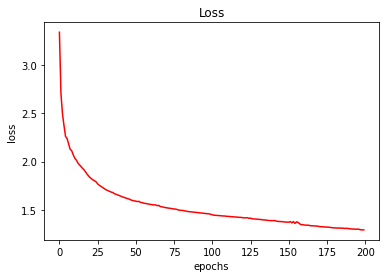

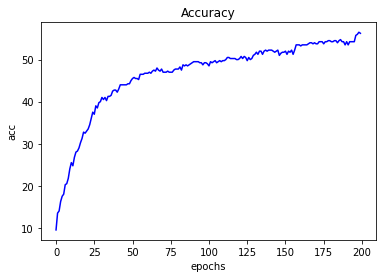

In [62]:
#red "normal"
N , F , C = 400 , 200 , 10
dataset = RandomDataset(N,F,C)
model = FFNN(F,[50,30],[relu,sig],C)
optimizer = SGD(list(model.parameters()),0.1)
with torch.no_grad():
  loss,acc = entrenar_FFNN(model,dataset,optimizer,epochs=200, batch_size=8, device='cpu')
plot_results(loss,acc)

Epoch:200 Acc:13.25% Loss:4.4620

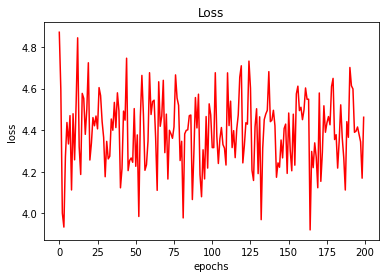

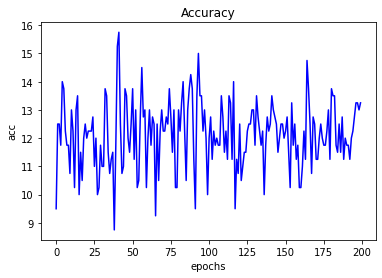

In [61]:
#red con lr alto
N , F , C = 400 , 200 , 10
dataset = RandomDataset(N,F,C)
model = FFNN(F,[50,30],[relu,sig],C)
optimizer = SGD(list(model.parameters()),1)
with torch.no_grad():
  loss,acc = entrenar_FFNN(model,dataset,optimizer,epochs=200, batch_size=8, device='cpu')
plot_results(loss,acc)
#es cualquier cosa (demasiado ruido)

Epoch:200 Acc:13.25% Loss:3.7816

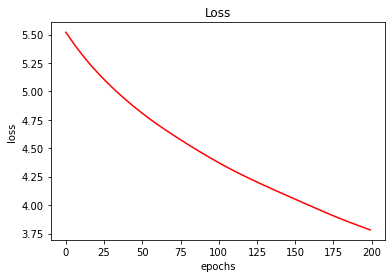

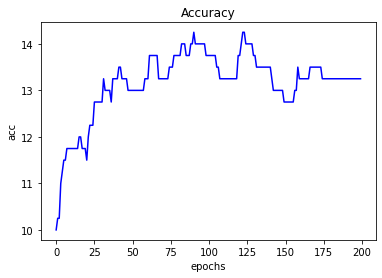

In [64]:
#red con lr muy bajo
N , F , C = 400 , 200 , 10
dataset = RandomDataset(N,F,C)
model = FFNN(F,[50,30],[relu,sig],C)
optimizer = SGD(list(model.parameters()),0.0001)
with torch.no_grad():
  loss,acc = entrenar_FFNN(model,dataset,optimizer,epochs=200, batch_size=8, device='cpu')
plot_results(loss,acc)
#se ve que aumenta la acc pero es demasiado lento (y un poco inestable)

Epoch:200 Acc:79.25% Loss:0.4677

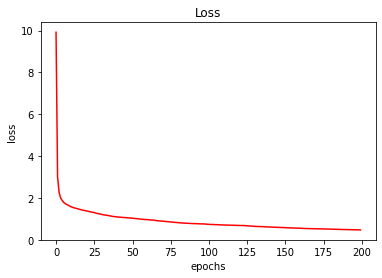

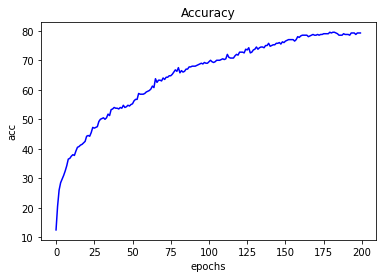

In [66]:
# red con solo 1 capa escondida
N , F , C = 400 , 200 , 10
dataset = RandomDataset(N,F,C)
model = FFNN(F,[50],[relu],C)
optimizer = SGD(list(model.parameters()),0.1)
with torch.no_grad():
  loss,acc = entrenar_FFNN(model,dataset,optimizer,epochs=200, batch_size=8, device='cpu')
plot_results(loss,acc)
# se ve que predice mejor que una red con mas capas (puede ser debido a que al tener menos parametros es mas facil ajustarlos para memorizar los ejemplos)

Epoch:200 Acc:15.12% Loss:2.0080

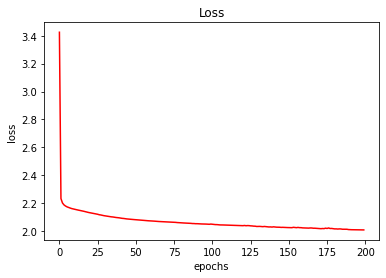

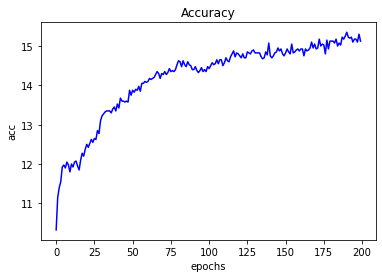

In [68]:
# red con solo 1 capa escondida y muchos ejemplos
N , F , C = 4000 , 200 , 10
dataset = RandomDataset(N,F,C)
model = FFNN(F,[50],[relu],C)
optimizer = SGD(list(model.parameters()),0.1)
with torch.no_grad():
  loss,acc = entrenar_FFNN(model,dataset,optimizer,epochs=200, batch_size=8, device='cpu')
plot_results(loss,acc)
#al ser muchos ejemplos la red no logra memorizarlos de buena manera (son demasidos)

Epoch:200 Acc:10.00% Loss:2.2153

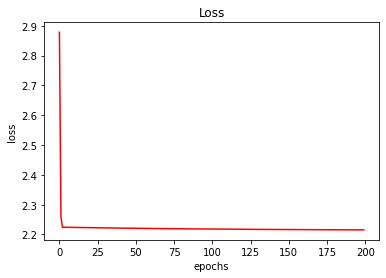

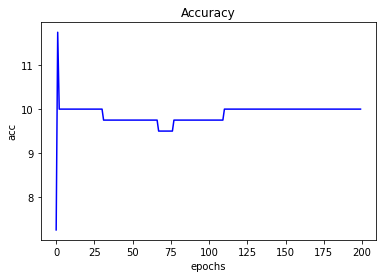

In [70]:
#red con muchas capas escondidas
N , F , C = 400 , 200 , 10
dataset = RandomDataset(N,F,C)
model = FFNN(F,[50,30,80,100,76,20],[relu,sig,tanh,relu,relu,sig],C)
optimizer = SGD(list(model.parameters()),0.1)
with torch.no_grad():
  loss,acc = entrenar_FFNN(model,dataset,optimizer,epochs=200, batch_size=8, device='cpu')
plot_results(loss,acc)
#el modelo es muy complejo y no logra ajustar todos sus parametro para ir adaptandose (o memorizando) todos los ejemplos

Epoch:200 Acc:16.50% Loss:2.0840

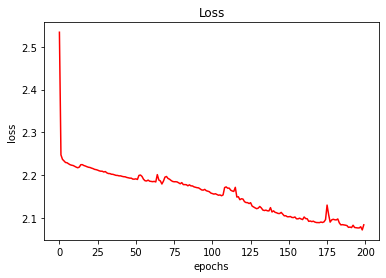

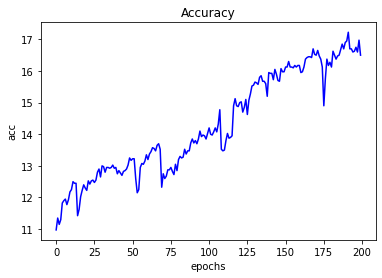

In [71]:
#muchos ejemplos
N , F , C = 4000 , 200 , 10
dataset = RandomDataset(N,F,C)
model = FFNN(F,[50,30],[relu,sig],C)
optimizer = SGD(list(model.parameters()),0.1)
with torch.no_grad():
  loss,acc = entrenar_FFNN(model,dataset,optimizer,epochs=200, batch_size=8, device='cpu')
plot_results(loss,acc)
#se ve que le cuesta mucho mas aprenderse los ejemplos (pues son demasiados), pero uno puede extrapolar que si lo dejaramos mas tiempo deberian haber mas mejorias

Epoch:1000 Acc:29.78% Loss:1.6839

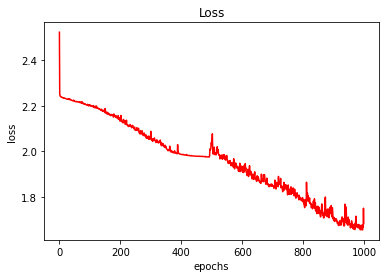

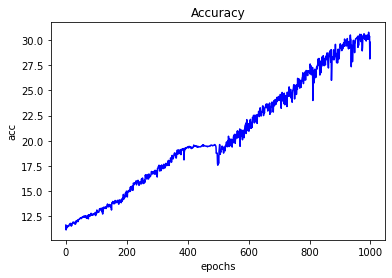

In [72]:
#caso anterior pero con muchas epocas
N , F , C = 4000 , 200 , 10
dataset = RandomDataset(N,F,C)
model = FFNN(F,[50,30],[relu,sig],C)
optimizer = SGD(list(model.parameters()),0.1)
with torch.no_grad():
  loss,acc = entrenar_FFNN(model,dataset,optimizer,epochs=1000, batch_size=8, device='cpu')
plot_results(loss,acc)
#se ve que aumenta la acc pero cada vez es menos

Epoch:200 Acc:40.00% Loss:2.0166

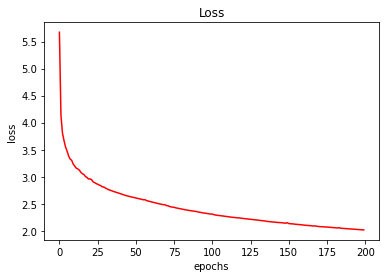

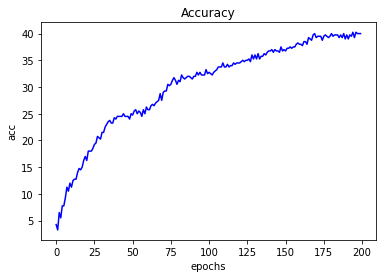

In [74]:
#Mas cantidad de clase
N , F , C = 400 , 200 , 30
dataset = RandomDataset(N,F,C)
model = FFNN(F,[50,30],[relu,sig],C)
optimizer = SGD(list(model.parameters()),0.1)
with torch.no_grad():
  loss,acc = entrenar_FFNN(model,dataset,optimizer,epochs=200, batch_size=8, device='cpu')
plot_results(loss,acc)
#se ve que el numero de clases no influye mucho en la precision de la red

## 4e) Opcional: Optimizando tu red para MNIST

In [ ]:
# Tu código de carga de datos, creación de la red, 
# entrenamiento/optimización y reportes acá